# BioMistral-7B SFT with MedQA datasets
These notebooks show the process of supervised fine-tuning of the base model bio mistral-7 using the medQA DataSet.

## Load the base model

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch


local_model_dir = "./BioMistral-7B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)


tokenizer = AutoTokenizer.from_pretrained(local_model_dir)
model = AutoModelForCausalLM.from_pretrained(local_model_dir, quantization_config=bnb_config)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


## Load the training datasets and tokenization

In [ ]:
import pandas as pd
from datasets import Dataset
# load training datasets
train_df = pd.read_csv('MedQA/med_qa_train.csv')
validation_df = pd.read_csv('MedQA/med_qa_validation.csv')
test_df = pd.read_csv('MedQA/med_qa_test.csv')

# Convert DataFrame to datasets.Dataset
train_dataset = Dataset.from_pandas(train_df)
validation_dataset = Dataset.from_pandas(validation_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
import ast
import re
tokenizer.pad_token = tokenizer.eos_token
def generate_and_tokenize_prompt(examples):
    options = {
        'A': examples['A'],
        'B': examples['B'],
        'C': examples['C'],
        'D': examples['D']
    }
    # Convert options to a formatted string, with each option on a new line
    option_str = '\n'.join([f"{k}: {v}" for k, v in options.items()])

    # Build the complete prompt text
    prompt_str = f"""From the MedmcQA Dataset: Given the medical question, provide an accurate answer.

    ###Question:
    {examples['question']} ?

    ###Options:\n{option_str}

    ###Answers:
    {examples['cop']}: {examples['Answer']}"""

    result = tokenizer(
        prompt_str,
        truncation=True,
        max_length=256,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

# Apply to training and validation sets
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt, batched=False)
tokenized_val_dataset = validation_dataset.map(generate_and_tokenize_prompt, batched=False)


Map:   0%|          | 0/12690 [00:00<?, ? examples/s]

Map:   0%|          | 0/3172 [00:00<?, ? examples/s]

In [ ]:
train_dataset[0]

{'question': 'All of the following are surgical options for morbid obesity except -',
 'A': 'Adjustable gastric banding',
 'B': 'Biliopancreatic diversion',
 'C': 'Duodenal Switch',
 'D': 'Roux en Y Duodenal By pass',
 'cop': 'C',
 'Answer': 'Duodenal Switch'}

In [ ]:
# Decode the tokenized text back to a string using the tokenizer
untokenized_text = tokenizer.decode(tokenized_train_dataset[1]['input_ids'])
print(untokenized_text)

</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><s> From the MedmcQA Dataset: Given the medical question, provide an accurate answer.

    ###Question:
    A 60 yr old chronic smoker presents with painless gross hematuria of 1 day duration. Investigation of choice to know the cause of hematuria ?

    ###Options:
A: USG
B: X-ray KUB
C: Urine routine
D: Urine microscopy for malignant cytology cells
    
    ###Answers:
    C: Urine routine


## Observe the distribution of input lengths

15862


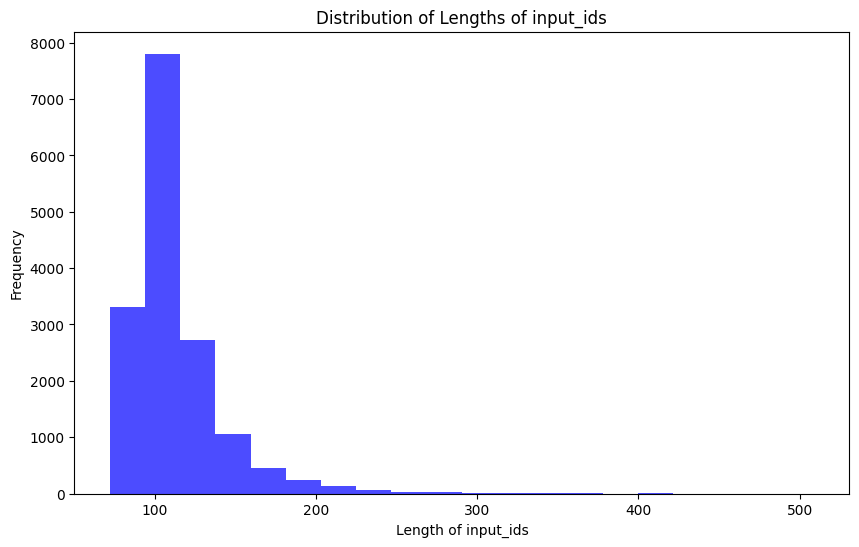

In [ ]:

import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

## Set the LORA config

In [ ]:
from peft import prepare_model_for_kbit_training
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)


model = get_peft_model(model, config)

In [ ]:
# Total number of trainable parameters
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
print_trainable_parameters(model)

trainable params: 21260288 || all params: 3773331456 || trainable%: 0.5634354746703705


## Set the finetune config and train

In [ ]:
import transformers
from datetime import datetime
import wandb

# Set up the project and run names
project = "biomistral-7B-MedmcQA-SFT"
base_model_name = "biomistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

# Set the W&B API key
wandb_api_key = "5f5f94d3de9157cf146ad88ecc4e0518a7a7549e"
wandb.login(key=wandb_api_key)

# Initialize a wandb run
wandb.init(project=project, name=run_name)

# Configure the Trainer
training_args = transformers.TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    num_train_epochs=5,
    learning_rate=2.5e-5,  # Wanted to be about 10x smaller than the Mistral learning rate
    bf16=True,
    optim="paged_adamw_8bit",
    evaluation_strategy="steps",
    eval_steps=200,  # Adjust the evaluation step size as needed
    logging_steps=500,  # The step size for logging
    save_steps=2000,  # The step size for saving the model
    report_to="wandb",
    run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
)

class WandbEvaluationCallback(transformers.TrainerCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # Log metrics at the end of each epoch
        if metrics:
            wandb.log(metrics)

trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    callbacks=[WandbEvaluationCallback()]
)

# Set model configuration
model.config.use_cache = False  # Silence the warnings. Please re-enable for inference!

# Start training and tracking
trainer.train()

# Finish the wandb run
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ziwei-chen-goo (ziwei-chen-goo-mbira-technologies). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.19.24, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


[2024-10-30 00:08:37,339] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.1), only 1.0.0 is known to be compatible


/usr/local/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
200,No log,0.864992
400,No log,0.842822
600,0.910500,0.827233
800,0.910500,0.816465
1000,0.811600,0.808202
1200,0.811600,0.800942
1400,0.811600,0.793905
1600,0.786100,0.788822


In [ ]:
model_device = next(model.parameters()).device

eval_prompt = """
What are the symptoms of Norrie disease ?
answer:
"""

# Encode the input and move it to the correct device
model_input = tokenizer(eval_prompt, return_tensors="pt").to(model_device)

# model.eval()

with torch.no_grad():
    # generate output
    output = model.generate(**model_input, max_new_tokens=500)
    # decode output
    answer = tokenizer.decode(output[0], skip_special_tokens=True)
    print(answer)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



What are the symptoms of Norrie disease ?
answer: 
 The Norrie disease is a rare X-linked recessive disorder that affects the development of the eyes and the brain. It is caused by a mutation in the NDP gene, which leads to the production of an abnormal protein. The symptoms of Norrie disease can vary widely, depending on the severity of the mutation. In general, affected individuals have vision problems, such as glaucoma, cataracts, and retinal detachment. They may also have hearing loss, learning disabilities, and behavioral problems. Some individuals with Norrie disease have severe developmental delay and intellectual disability, while others have more mild symptoms.
